In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
plt.style.reload_library()
plt.style.use('material')

from bonsai.helpers import BST

%load_ext autoreload
%autoreload 2

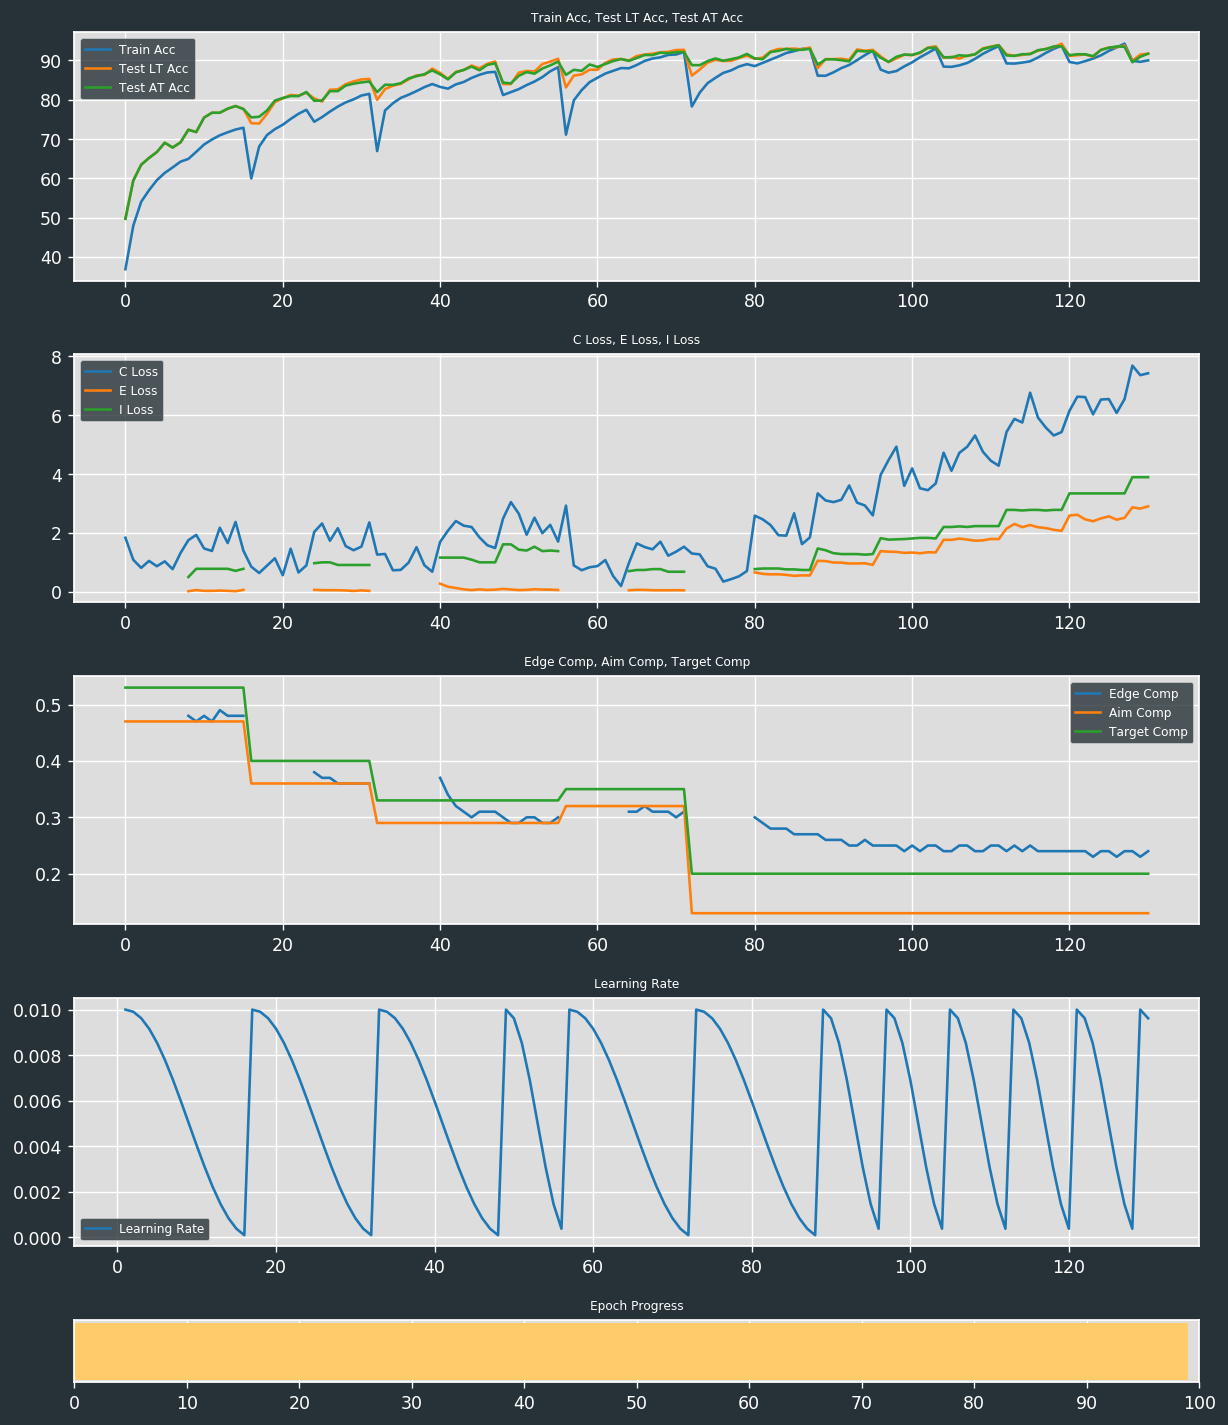

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec
import numpy as np

plt.style.reload_library()
plt.style.use('material')


def get_logs():
    with open("logs/jn_out.log","r") as f:
        out = f.read().replace('\x00','')
    return out.split("\n")


def time_parse(t):
    if "m" in t:
        return int(t.split("m")[0])*60+int(t.split(",")[1].split('s')[0])
    else:
        return float(t.split('s')[0])


def scrape():
    rows = []
    row = {}
    aim,target = 0,0
    logs = get_logs()
    curr_prog = int([log for log in logs if '%' in log  and 'Train Epoch' in log][-1].split("(")[1].split("%")[0])

    for line in logs:
        if line=="" and 'Test AT Acc' in row:
            row['Aim Comp']=aim
            row['Target Comp']=target
            if row:
                rows.append(row)
            row = {}
        if 'Adjusting lr' in line:
            row['Learning Rate']=float(line.split("to")[1].split("\x1b[0m")[0])
        if 'Target Comp' in line:
            target = float(line.split(":")[1].split(",")[0])
            if 'Aim' in line:
                aim = float(line.split(":")[-1])
        if 'Train Epoch' in line:
            if 'Loss:' in line:
                row['C Loss']=float(line.split(":")[2].split(",")[0])
            row['Alloc']=float(line.split(":")[-1].split("GiB")[0])
        if 'Train Corrects' in line:
            row['Train Acc']= float(line.split(":")[2].split(",")[0][:-1])
            if 'Comp' in line:
                row['Edge Comp'] = float(line.split(":")[3].split(",")[0])
                row['Input Comp'] = float(line.split(":")[3].split(" ")[2])
            row['Runtime'] = time_parse(line.split(" ")[-1].strip())
        if 'Train Loss Components' in line:
            row['C Loss'] = float(line.split(":")[2].split(",")[0])
            row['E Loss'] = float(line.split(":")[3].split(",")[0])
            row['I Loss'] = float(line.split(":")[4].split(",")[0])
        if 'Test' in line and 'Corrects' in line:
            if 'All Towers' in line:
                row['Test AT Acc']= float(line.split(":")[2].split("%")[0])
            elif 'Last Tower' in line:
                row['Test LT Acc']= float(line.split(":")[2].split("%")[0])
    return pd.DataFrame(rows), curr_prog


class Animator:
    def __init__(self,axes, col_sets):
        self.axes = axes
        self.col_sets = col_sets
        self.prog = 0

    def animate(self,i):
        df, prog = scrape()
        cycles = []
        if 'E_Loss' in list(df):
            e_losses = df[df['E_Loss'].isnull()].index
            cycles = [x for i, x in enumerate(e_losses) if x != e_losses[i - 1] + 1]

        for i,cols in enumerate(self.col_sets):
            dmin, dmax = 1000, 0
            self.axes[i].clear()
            for label in cols:
                if label not in list(df):
                    continue
                self.axes[i].plot(df[label], label=label)
                if df[label].min(skipna=True) < dmin:
                    dmin = df[label].min(skipna=True)
                if df[label].max(skipna=True) > dmax:
                    dmax = df[label].max(skipna=True)
            for cycle in cycles:
                self.axes[i].plot([cycle] * 100, np.linspace(dmin, dmax, 100), c='k', alpha=.25)
            if len(df):
                self.axes[i].legend(fontsize=7)
            self.axes[i].set_title(", ".join(cols),fontsize=7)

        if prog != self.prog:
            self.axes[-1].clear()
            self.axes[-1].barh(1, prog, align='center',color='#FFCB6B')
            self.axes[-1].set_xlim(0, 100)
            self.axes[-1].set_title("Epoch Progress",fontsize=7)
            self.axes[-1].set_yticks([])
            self.axes[-1].set_xticks(range(0,110,10))
            self.prog = prog
        return self.axes


def plot(col_sets):
    fig = plt.figure(figsize=(10, 12), dpi=125)
    gs = gridspec.GridSpec(len(col_sets)+1, 1, height_ratios=[1]*len(col_sets)+[.25])
    axes = [plt.subplot(g) for g in gs]
    plt.subplots_adjust(left=.05, right=.95, top=.95, bottom=.05, hspace=.35)
    animator = Animator(axes, col_sets)
    ani = animation.FuncAnimation(fig, animator.animate, interval=1000)
    plt.show()

plot([
    ['Train Acc', 'Test LT Acc', 'Test AT Acc'],
    ['C Loss', 'E Loss', 'I Loss'],
    ['Edge Comp', 'Aim Comp', 'Target Comp'],
    ['Learning Rate']
])